<a href="https://colab.research.google.com/github/mrbarron3/fwe458/blob/main/final_project/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigating the Prevalence of and Fatalities Caused by Tsunamis

In [ ]:
# imports
import pandas as pd
from google.colab import drive

!pip install cartopy
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors

import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree

from sklearn.linear_model import LinearRegression, LogisticRegression

import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import root_mean_squared_error

from geopy import distance

from collections import Counter
from imblearn.over_sampling import RandomOverSampler

import copy
# from scipy.optimize import minimize
# from sklearn.metrics import r2_score

In [ ]:
# Import Data
drive.mount('/content/drive')

filedir = "/content/drive/My Drive/"
#filedir = "/content/drive/MyDrive/Spring '25/FWE458/final_project/"

fname = filedir + "tsunami.csv"

Mounted at /content/drive


## Reading in the Data

In [ ]:
# read in the csv file
df = pd.read_csv(fname)

print(f"Whole df length: {len(df)}")
print(f"Length with no NaN values: {len(df.dropna())}")

print(f"Years present in the data: {df['YEAR'].min()} through {df['YEAR'].max()}")

print(f"Columns in the dataframe: {df.columns}")
df.sort_values(by = "YEAR", inplace = True)
df[["YEAR", "MONTH", 'DAY', 'HOUR', 'MINUTE', 'LATITUDE', 'LONGITUDE', 'COUNTRY', 'REGION', 'CAUSE', 'EVENT_VALIDITY', 'EQ_MAGNITUDE', 'EQ_DEPTH', 'TS_INTENSITY', 'DAMAGE_TOTAL_DESCRIPTION', 'HOUSES_TOTAL_DESCRIPTION', 'DEATHS_TOTAL_DESCRIPTION']].head()

Whole df length: 2259
Length with no NaN values: 121
Years present in the data: -2000 through 2020
Columns in the dataframe: Index(['ID', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'LATITUDE', 'LONGITUDE',
       'LOCATION_NAME', 'COUNTRY', 'REGION', 'CAUSE', 'EVENT_VALIDITY',
       'EQ_MAGNITUDE', 'EQ_DEPTH', 'TS_INTENSITY', 'DAMAGE_TOTAL_DESCRIPTION',
       'HOUSES_TOTAL_DESCRIPTION', 'DEATHS_TOTAL_DESCRIPTION', 'URL',
       'COMMENTS'],
      dtype='object')


,YEAR,MONTH,DAY,HOUR,MINUTE,LATITUDE,LONGITUDE,COUNTRY,REGION,CAUSE,EVENT_VALIDITY,EQ_MAGNITUDE,EQ_DEPTH,TS_INTENSITY,DAMAGE_TOTAL_DESCRIPTION,HOUSES_TOTAL_DESCRIPTION,DEATHS_TOTAL_DESCRIPTION
197,-2000,NaN,NaN,NaN,NaN,35.683,35.80,SYRIA,Mediterranean Sea,Earthquake,Very Doubtful Tsunami,NaN,NaN,6.0,Extreme (~$25 million or more),NaN,Many (~101 to 1000 people)
218,-1610,NaN,NaN,NaN,NaN,36.400,25.40,GREECE,Mediterranean Sea,Volcano,Definite Tsunami,NaN,NaN,6.0,Severe (~>$5 to $24 million),NaN,Many (~101 to 1000 people)
43,-1365,NaN,NaN,NaN,NaN,35.683,35.80,SYRIA,Mediterranean Sea,Earthquake,Very Doubtful Tsunami,NaN,NaN,6.0,Severe (~>$5 to $24 million),NaN,NaN
4,-1300,NaN,NaN,NaN,NaN,39.960,26.24,TURKEY,Mediterranean Sea,Unknown,Questionable Tsunami,6.0,NaN,5.0,NaN,NaN,NaN
55,-590,NaN,NaN,NaN,NaN,33.270,35.22,LEBANON,Mediterranean Sea,Earthquake,Questionable Tsunami,NaN,NaN,6.0,NaN,NaN,NaN


In [ ]:
water_temp = pd.read_csv(filedir + 'water_temp.csv')

# read in the water temperature data and clean it (first time, now saved and downloaded into "water_temp.csv" dataset)
# water_temp = pd.read_csv('https://www.ncei.noaa.gov/data/oceans/woa/DATA_ANALYSIS/3M_HEAT_CONTENT/DATA/basin/pentad/pent_h22-w0-2000m.dat', sep = '  ')
# display(water_temp.head())
# water_temp.rename(columns = {"WO": 'NH', "WOse": "SH", 'Unnamed: 1': "WO", "Unnamed: 2": "WOse", "Unnamed: 4": "NHse", "Unnamed: 6": "SHse"}, inplace = True)
# water_temp.dropna(axis = 1, inplace = True)
# print(water_temp.columns)
# water_temp['YEAR'] = np.floor(water_temp['YEAR']).astype(int)
# drop the first year as the values are comparisons to that year
# water_temp.to_csv(filedir + 'water_temp.csv', index = False)
water_temp = water_temp[water_temp["YEAR"] >= 1958]
water_temp.head()

,YEAR,WO,WOse,NH,NHse,SH,SHse
0,1958,-8.059,2.017,-2.321,0.851,-5.738,1.166
1,1959,-8.713,2.036,-2.505,0.824,-6.208,1.212
2,1960,-5.479,1.893,-1.587,0.746,-3.892,1.148
3,1961,-4.762,1.773,-1.936,0.711,-2.826,1.061
4,1962,-4.121,1.728,-2.022,0.645,-2.100,1.082


In [ ]:
pop = pd.read_csv(filedir + "population.csv")
pop.head()

,Lat,Lon,Title,rank,Country,2021 pop.,2020 pop.,Growth,popDiff,popChg
0,35.682839,139.759455,Tokyo,1,Japan,37339804,37393128,-0.0014,53324,declined
1,28.651718,77.221939,Delhi,2,India,31181376,30290936,0.0294,890440,grew
2,31.232276,121.469207,Shanghai,3,China,27795702,27058480,0.0272,737222,grew
3,-23.550651,-46.633382,Sao Paulo,4,Brazil,22237472,22043028,0.0088,194444,grew
4,19.432630,-99.133178,Mexico City,5,Mexico,21918936,21782378,0.0063,136558,grew


In [ ]:
def eq(cause):
  if pd.isna(cause):
    return None
  if "Earthquake" in cause:
    return 1
  else:
    return 0

# add in another column for whether a tsunami was caused by an Earthquake (fully or in part)
df["eq"] = df["CAUSE"].apply(eq)
df

,ID,YEAR,MONTH,DAY,HOUR,MINUTE,LATITUDE,LONGITUDE,LOCATION_NAME,COUNTRY,...,EVENT_VALIDITY,EQ_MAGNITUDE,EQ_DEPTH,TS_INTENSITY,DAMAGE_TOTAL_DESCRIPTION,HOUSES_TOTAL_DESCRIPTION,DEATHS_TOTAL_DESCRIPTION,URL,COMMENTS,eq
197,1,-2000,NaN,NaN,NaN,NaN,35.683,35.800,SYRIAN COASTS,SYRIA,...,Very Doubtful Tsunami,NaN,NaN,6.0,Extreme (~$25 million or more),NaN,Many (~101 to 1000 people),https://www.ngdc.noaa.gov/hazel/view/hazards/t...,Second millennium B.C.\r\n<br>According to exc...,1.0
218,3,-1610,NaN,NaN,NaN,NaN,36.400,25.400,THERA ISLAND (SANTORINI),GREECE,...,Definite Tsunami,NaN,NaN,6.0,Severe (~>$5 to $24 million),NaN,Many (~101 to 1000 people),https://www.ngdc.noaa.gov/hazel/view/hazards/t...,"1410 B.C., 36.4 N, 25.4 E, tsunami intensity v...",0.0
43,4,-1365,NaN,NaN,NaN,NaN,35.683,35.800,SYRIAN COASTS,SYRIA,...,Very Doubtful Tsunami,NaN,NaN,6.0,Severe (~>$5 to $24 million),NaN,NaN,https://www.ngdc.noaa.gov/hazel/view/hazards/t...,"1365 <u>+</u> 5 B.C. Aegean Sea, Asia Minor. A...",1.0
4,5,-1300,NaN,NaN,NaN,NaN,39.960,26.240,"IONIAN COASTS, TROAD",TURKEY,...,Questionable Tsunami,6.0,NaN,5.0,NaN,NaN,NaN,https://www.ngdc.noaa.gov/hazel/view/hazards/t...,1300 B.C. Ionian and Aegean Seas. References t...,0.0
55,7,-590,NaN,NaN,NaN,NaN,33.270,35.220,LEBANON COASTS,LEBANON,...,Questionable Tsunami,NaN,NaN,6.0,NaN,NaN,NaN,https://www.ngdc.noaa.gov/hazel/view/hazards/t...,"590 B.C. Levantian Sea, Near East. Possibly, t...",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2246,5740,2020,1.0,28.0,19.0,10.0,19.440,-78.755,OFF SE COAST,CUBA,...,Definite Tsunami,7.7,10.0,NaN,Moderate (~$1 to $5 million),Few (~1 to 50 houses),NaN,https://www.ngdc.noaa.gov/hazel/view/hazards/t...,NaN,1.0
2253,5748,2020,5.0,29.0,5.0,30.0,-8.058,114.242,LESSER SUNDA: BALI: IJEN VOLCANO,INDONESIA,...,Event that only caused a seiche or disturbance...,NaN,NaN,NaN,NaN,NaN,Few (~1 to 50 people),https://www.ngdc.noaa.gov/hazel/view/hazards/t...,A sulfur miner was killed when volcanic activi...,1.0
2254,5753,2020,7.0,22.0,6.0,12.0,55.030,-158.522,"SHUMAGIN ISLANDS, AK",USA,...,Definite Tsunami,7.8,28.0,NaN,NaN,NaN,NaN,https://www.ngdc.noaa.gov/hazel/view/hazards/t...,NaN,1.0
2255,5750,2020,6.0,18.0,12.0,49.0,-33.294,-177.838,"S OF RAOUL ISLAND, KERMADEC ISLANDS",NEW ZEALAND,...,Definite Tsunami,7.4,10.0,NaN,NaN,NaN,NaN,https://www.ngdc.noaa.gov/hazel/view/hazards/t...,A small tsunami (12 cm) occurred today followi...,1.0


## closest major city column addition

In [ ]:
# takes a very long time to run

# df["distance_to_city"] = 999
# df["city_name"] = 999
# df["city_pop"] = 999

# for index, tsu_row in df.iterrows():
#     best_dist = None
#     best_name = None
#     best_pop = None
#     a = (tsu_row["LATITUDE"], tsu_row["LONGITUDE"])
#     for i, pop_row in pop.iterrows():
#       b = (pop_row["Lat"], pop_row["Lon"])
#       km = distance.distance(a, b).km
#       if best_dist is None or km < best_dist:
#           best_dist = km
#           best_name = pop_row["Title"]
#           best_pop = pop_row["2020 pop."]
#     df.at[index, "distance_to_city"] = best_dist
#     df.at[index, "city_name"] = best_name
#     df.at[index, "city_pop"] = best_pop

# df.to_csv(filedir + 'full_df.csv', index = False)
# df_1958 = df[df["YEAR"] >= 1958]
# df_1958.to_csv(filedir + 'df_1958.csv', index = False)

# saved all previous code to two datasets: full_df.csv and "df_1958.csv"

df = pd.read_csv(filedir + "full_df.csv")
df_1958 = pd.read_csv(filedir + "df_1958.csv")
df_1958 = df_1958[(df_1958["EVENT_VALIDITY"].str.contains("Probable")) | (df_1958["EVENT_VALIDITY"].str.contains("Definite"))]

## joining the ocean heat content change dataset

In [ ]:
def water_temp_change(year, lat):
  # southern hemisphere
  if year < 1958:
    return None
  if lat < 0:
    return water_temp[water_temp["YEAR"] == year]["SH"].iloc[0]
  # northern hemisphere
  if lat > 0:
    return water_temp[water_temp["YEAR"] == year]["NH"].iloc[0]
  # equator
  if lat == 0:
    return water_temp[water_temp["YEAR"] == year]["WO"].iloc[0]
  else:
    return None

df['water_temp_change'] = df.apply(lambda row: water_temp_change(row['YEAR'], row['LATITUDE']), axis=1)
# df_1958 = df[df["YEAR"] >= 1958]
df_1958.head()

,ID,YEAR,MONTH,DAY,HOUR,MINUTE,LATITUDE,LONGITUDE,LOCATION_NAME,COUNTRY,...,DAMAGE_TOTAL_DESCRIPTION,HOUSES_TOTAL_DESCRIPTION,DEATHS_TOTAL_DESCRIPTION,URL,COMMENTS,eq,distance_to_city,city_name,city_pop,water_temp_change
2,1884,1958,11.0,6.0,22.0,58.0,44.53,148.540,S. KURIL ISLANDS,RUSSIA,...,Moderate (~$1 to $5 million),NaN,NaN,https://www.ngdc.noaa.gov/hazel/view/hazards/t...,"Destruction on Iturup, Urup, Kunashir, and Les...",1.0,600.640696,Sapporo,2669680,-2.321
3,1877,1958,1.0,19.0,14.0,7.0,1.50,-79.500,COLOMBIA-ECUADOR,ECUADOR,...,Moderate (~$1 to $5 million),Some (~51 to 100 houses),Many (~101 to 1000 people),https://www.ngdc.noaa.gov/hazel/view/hazards/t...,"On January 19, 1958, at 9:09 [local time] ther...",1.0,219.691645,Quito,1873763,-2.321
8,1880,1958,7.0,10.0,6.0,15.0,58.37,-136.665,"SE. ALASKA, AK",USA,...,Limited (<$1 million),Few (~1 to 50 houses),Few (~1 to 50 people),https://www.ngdc.noaa.gov/hazel/view/hazards/t...,"At least 8 separate tsunamis, generated by sub...",1.0,1345.738208,Vancouver,2581079,-2.321
10,1886,1959,1.0,22.0,5.0,10.0,37.50,142.200,SANRIKU,JAPAN,...,NaN,NaN,NaN,https://www.ngdc.noaa.gov/hazel/view/hazards/t...,<P><blockquote><i>Reference #414:</i></blockqu...,1.0,144.802650,Sendai,2327417,-2.505
13,1892,1959,8.0,17.0,21.0,4.0,-7.50,156.000,SOLOMON ISLANDS,SOLOMON ISLANDS,...,Severe (~>$5 to $24 million),NaN,NaN,https://www.ngdc.noaa.gov/hazel/view/hazards/t...,At Binskin islet (or Inia) south of Vella and ...,1.0,2232.439671,Brisbane,2406182,-6.208


## Data Exploration

In [ ]:
df.head()

,ID,YEAR,MONTH,DAY,HOUR,MINUTE,LATITUDE,LONGITUDE,LOCATION_NAME,COUNTRY,...,DAMAGE_TOTAL_DESCRIPTION,HOUSES_TOTAL_DESCRIPTION,DEATHS_TOTAL_DESCRIPTION,URL,COMMENTS,eq,distance_to_city,city_name,city_pop,water_temp_change
0,1,-2000,NaN,NaN,NaN,NaN,35.683,35.80,SYRIAN COASTS,SYRIA,...,Extreme (~$25 million or more),NaN,Many (~101 to 1000 people),https://www.ngdc.noaa.gov/hazel/view/hazards/t...,Second millennium B.C.\r\n<br>According to exc...,1.0,18.191584,Lattakia,655714,NaN
1,3,-1610,NaN,NaN,NaN,NaN,36.400,25.40,THERA ISLAND (SANTORINI),GREECE,...,Severe (~>$5 to $24 million),NaN,Many (~101 to 1000 people),https://www.ngdc.noaa.gov/hazel/view/hazards/t...,"1410 B.C., 36.4 N, 25.4 E, tsunami intensity v...",0.0,230.058807,Athens,3153355,NaN
2,4,-1365,NaN,NaN,NaN,NaN,35.683,35.80,SYRIAN COASTS,SYRIA,...,Severe (~>$5 to $24 million),NaN,NaN,https://www.ngdc.noaa.gov/hazel/view/hazards/t...,"1365 <u>+</u> 5 B.C. Aegean Sea, Asia Minor. A...",1.0,18.191584,Lattakia,655714,NaN
3,5,-1300,NaN,NaN,NaN,NaN,39.960,26.24,"IONIAN COASTS, TROAD",TURKEY,...,NaN,NaN,NaN,https://www.ngdc.noaa.gov/hazel/view/hazards/t...,1300 B.C. Ionian and Aegean Seas. References t...,0.0,188.472398,Izmir,2992953,NaN
4,7,-590,NaN,NaN,NaN,NaN,33.270,35.22,LEBANON COASTS,LEBANON,...,NaN,NaN,NaN,https://www.ngdc.noaa.gov/hazel/view/hazards/t...,"590 B.C. Levantian Sea, Near East. Possibly, t...",1.0,54.119937,Haifa,1147431,NaN


I'm choosing to not drop Nan values right now because of how many values are missing overall. Some of the missing values are in columns I won't be needing for any regression, such as the COMMENTS column. I will work around these values and only drop when necessary.

In [ ]:
# make sure that no rows are missing lat or long and event_validity before plotting
len(df[(~df['LATITUDE'].isna()) & (~df['LONGITUDE'].isna()) & (~df['EVENT_VALIDITY'].isna())]) == len(df)

True

## Pairplot General Exploration

In [ ]:
# takes a long time to run, doesn't show any significant noticeable correlations

# fig, ax = plt.subplots(figsize=(15,5))
# sns.pairplot(data = df)

# plt.show()

## Tsunami Location Occurences visualization

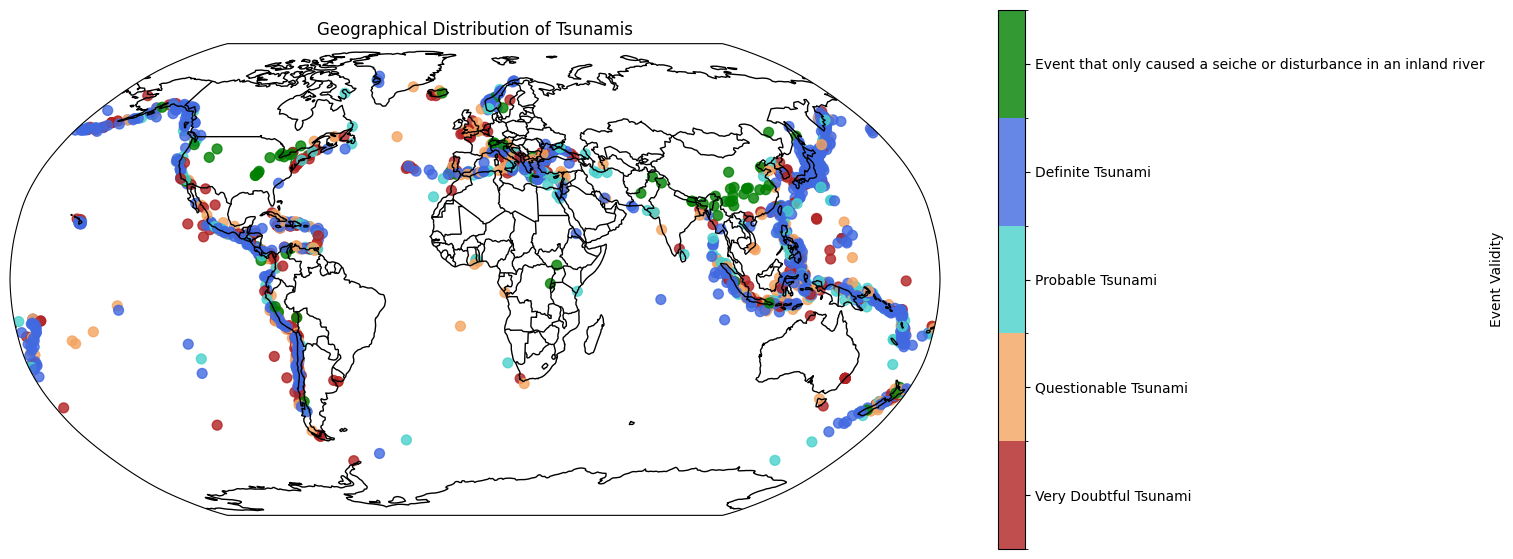

In [ ]:
# Create a color mapping for event validity
event_validity_colors = {
    'Very Doubtful Tsunami': 'firebrick',
    'Questionable Tsunami': 'sandybrown',
    'Probable Tsunami': 'mediumturquoise',
    'Definite Tsunami': 'royalblue',
    'Event that only caused a seiche or disturbance in an inland river': 'green',
}

# Create the figure and axes
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# Add coastlines and land features
ax.coastlines()
ax.add_feature(cfeature.BORDERS)


# Map event validity to colors
categories = list(event_validity_colors.keys())
colors = list(event_validity_colors.values())

cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(range(len(categories) + 1), cmap.N)


# Create the scatter plot with color mapping
scatter = ax.scatter(
    df['LONGITUDE'],
    df['LATITUDE'],
    c=[categories.index(c) for c in df['EVENT_VALIDITY']],
    cmap=cmap,
    norm=norm,
    alpha=0.8,
    s=50,
    transform=ccrs.PlateCarree(),
)


# Add a colorbar
cbar = plt.colorbar(scatter, ax=ax, ticks=[i + 0.5 for i in range(len(categories))], shrink=0.7)
cbar.set_label('Event Validity')
cbar.ax.set_yticklabels(categories)


# Set the title and axis labels
plt.title('Geographical Distribution of Tsunamis')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Set the extent of the map (adjust as needed)
ax.set_global()

# Display the plot
plt.show()

## Distribution of Tsunamis by Year

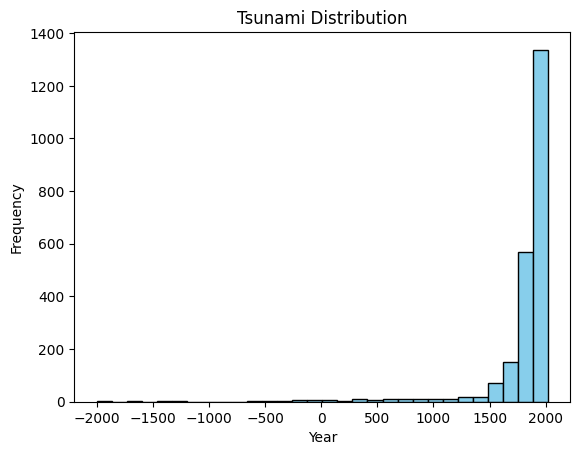

In [ ]:
df_year = df[~(df["YEAR"].isna())]

plt.hist(df_year["YEAR"], bins=30, color='skyblue', edgecolor='black')

plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Tsunami Distribution')

plt.show()

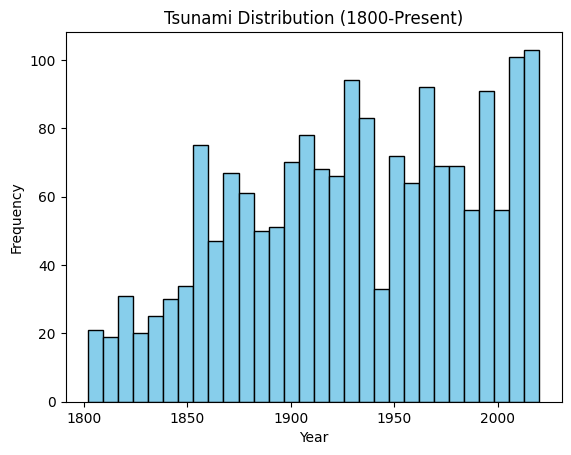

In [ ]:
# zooming in on 1800-present
# official tsunami recording began in the 1900s

df_year18 = df_year[df_year["YEAR"] >= 1800]

plt.hist(df_year18["YEAR"], bins=30, color='skyblue', edgecolor='black')

plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Tsunami Distribution (1800-Present)')

plt.show()

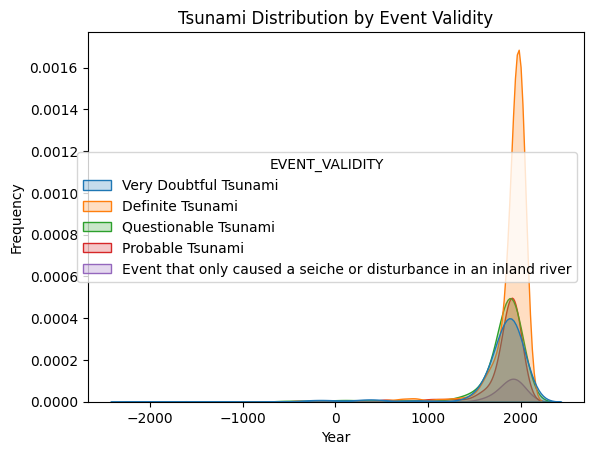

In [ ]:
# density plot displaying tsunami prevalence over the years
# plt.density(df_year["YEAR"], bins=30, color=df_year['EVENT_VALIDITY'], edgecolor='black')
sns.kdeplot(data=df_year, x='YEAR', hue='EVENT_VALIDITY', fill=True)

plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Tsunami Distribution by Event Validity')

plt.show()

The average number of yearly tsunamis from 1850 to 2020 is 8.276497695852534


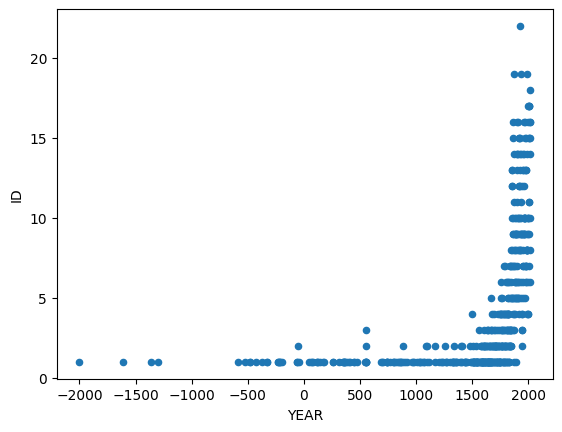

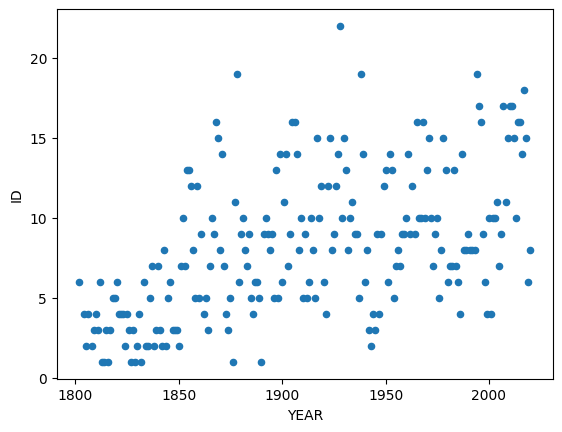

In [ ]:
# count up the number of tsunamis every year
year_groups = df.groupby("YEAR").count()["ID"].reset_index()

year_groups.plot(x = "YEAR", y = "ID", kind = "scatter")

year_groups[year_groups["YEAR"] > 1800].plot(x = "YEAR", y = "ID", kind = "scatter")

print(f"The average number of yearly tsunamis from 1850 to 2020 is {float(year_groups[year_groups['YEAR'] > 1800]['ID'].mean())}")

<Axes: xlabel='YEAR', ylabel='TS_INTENSITY'>

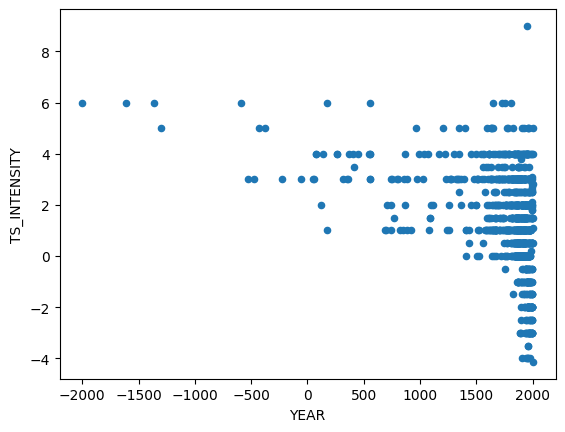

In [ ]:
# tsunami intensity over the years
df.plot(x = "YEAR", y = "TS_INTENSITY", kind = "scatter")

In [ ]:
# highest intensity tsunami
df[df["TS_INTENSITY"].max() == df["TS_INTENSITY"]]

,ID,YEAR,MONTH,DAY,HOUR,MINUTE,LATITUDE,LONGITUDE,LOCATION_NAME,COUNTRY,...,DAMAGE_TOTAL_DESCRIPTION,HOUSES_TOTAL_DESCRIPTION,DEATHS_TOTAL_DESCRIPTION,URL,COMMENTS,eq,distance_to_city,city_name,city_pop,water_temp_change
1476,1764,1946,8.0,2.0,19.0,18.0,-26.5,-70.5,NORTHERN CHILE,CHILE,...,Severe (~>$5 to $24 million),NaN,Few (~1 to 50 people),https://www.ngdc.noaa.gov/hazel/view/hazards/t...,"August 2, 1946, 19:19 UTC, 26.5 S, 70.5 W, mag...",1.0,528.450467,San Miguel de Tucuman,985656,NaN


In [ ]:
# deadliest tsunami on record
# 230,000 people
df[(df["YEAR"] == 2004) & (df["EQ_MAGNITUDE"] == 9.1)]

# worst tsunamis
df[(df["DAMAGE_TOTAL_DESCRIPTION"].str.contains("Extreme")) & (df["DEATHS_TOTAL_DESCRIPTION"].str.contains("Very")) & df["HOUSES_TOTAL_DESCRIPTION"].str.contains("Very")].tail()

,ID,YEAR,MONTH,DAY,HOUR,MINUTE,LATITUDE,LONGITUDE,LOCATION_NAME,COUNTRY,...,DAMAGE_TOTAL_DESCRIPTION,HOUSES_TOTAL_DESCRIPTION,DEATHS_TOTAL_DESCRIPTION,URL,COMMENTS,eq,distance_to_city,city_name,city_pop,water_temp_change
2040,2439,2004,12.0,26.0,0.0,58.0,3.316,95.854,OFF W. COAST OF SUMATRA,INDONESIA,...,Extreme (~$25 million or more),Very Many (~1001 or more houses),Very Many (~1001 or more people),https://www.ngdc.noaa.gov/hazel/view/hazards/t...,<blockquote><i>Reference #3969:</i></blockquot...,1.0,314.793088,Medan,2337958,6.407
2083,3586,2008,5.0,12.0,6.0,28.0,31.002,103.322,SICHUAN PROVINCE,CHINA,...,Extreme (~$25 million or more),Very Many (~1001 or more houses),Very Many (~1001 or more people),https://www.ngdc.noaa.gov/hazel/view/hazards/t...,"On May 12, 2008, at 06:28:00 UTC (2:28 PM loca...",1.0,80.434104,Chengdu,9135768,7.268
2123,4622,2010,1.0,12.0,21.0,53.0,18.457,-72.533,HAITI & DOMINICAN REPUBLIC,HAITI,...,Extreme (~$25 million or more),Very Many (~1001 or more houses),Very Many (~1001 or more people),https://www.ngdc.noaa.gov/hazel/view/hazards/t...,<blockquote><i>Ref #6477:</i></blockquote>\r\n...,1.0,22.739828,Port-au-Prince,2773553,7.360
2139,5413,2011,3.0,11.0,5.0,46.0,38.297,142.372,HONSHU ISLAND,JAPAN,...,Extreme (~$25 million or more),Very Many (~1001 or more houses),Very Many (~1001 or more people),https://www.ngdc.noaa.gov/hazel/view/hazards/t...,"The March 11, 2011 earthquake near the east co...",1.0,131.529894,Sendai,2327417,7.768
2236,5689,2018,9.0,28.0,10.0,2.0,-0.178,119.840,SULAWESI,INDONESIA,...,Extreme (~$25 million or more),Very Many (~1001 or more houses),Very Many (~1001 or more people),https://www.ngdc.noaa.gov/hazel/view/hazards/t...,"<P><blockquote><i>Ref #12235, 12237, 12246, 12...",1.0,302.758177,Samarinda,1010413,12.411


## Predicting Death


In [ ]:
# prediction options
display(df['DAMAGE_TOTAL_DESCRIPTION'].value_counts())
print(f"total: {df['DAMAGE_TOTAL_DESCRIPTION'].value_counts().sum()}")
# would need economic data

display(df['HOUSES_TOTAL_DESCRIPTION'].value_counts())
print(f"total: {df['HOUSES_TOTAL_DESCRIPTION'].value_counts().sum()}")
# least amount of data to work with

display(df['DEATHS_TOTAL_DESCRIPTION'].value_counts())
print(f"total: {df['DEATHS_TOTAL_DESCRIPTION'].value_counts().sum()}")

print(f"overall total: {len(df)}")

,count
DAMAGE_TOTAL_DESCRIPTION,
Limited (<$1 million),365
Moderate (~$1 to $5 million),276
Severe (~>$5 to $24 million),267
Extreme (~$25 million or more),147


total: 1055


,count
HOUSES_TOTAL_DESCRIPTION,
Many (~101 to 1000 houses),263
Very Many (~1001 or more houses),127
Few (~1 to 50 houses),124
Some (~51 to 100 houses),92


total: 606


,count
DEATHS_TOTAL_DESCRIPTION,
Few (~1 to 50 people),310
Many (~101 to 1000 people),172
Very Many (~1001 or more people),131
Some (~51 to 100 people),61


total: 674
overall total: 2259


In [ ]:
print(f"The different event validity markers are: {set(df_1958['EVENT_VALIDITY'])}")
print("I will be using tsunamis that were 'Definite' or 'Probable'")

tsu = df[(df["EVENT_VALIDITY"] == "Definite Tsunami") | (df["EVENT_VALIDITY"] == "Probable Tsunami")]

print(f"The length of the dataframe with just definite and probable tsunamis is: {len(tsu)}")
tsu["DEATHS_TOTAL_DESCRIPTION"].dropna()

The different event validity markers are: {'Probable Tsunami', 'Definite Tsunami'}
I will be using tsunamis that were 'Definite' or 'Probable'
The length of the dataframe with just definite and probable tsunamis is: 1287


,DEATHS_TOTAL_DESCRIPTION
1,Many (~101 to 1000 people)
8,Very Many (~1001 or more people)
9,Many (~101 to 1000 people)
26,Very Many (~1001 or more people)
40,Very Many (~1001 or more people)
...,...
2243,Many (~101 to 1000 people)
2244,Many (~101 to 1000 people)
2247,Few (~1 to 50 people)
2253,Few (~1 to 50 people)


790
DEATHS_TOTAL_DESCRIPTION
Few (~1 to 50 people)               227
Many (~101 to 1000 people)          123
Very Many (~1001 or more people)     99
Some (~51 to 100 people)             48
Name: count, dtype: int64


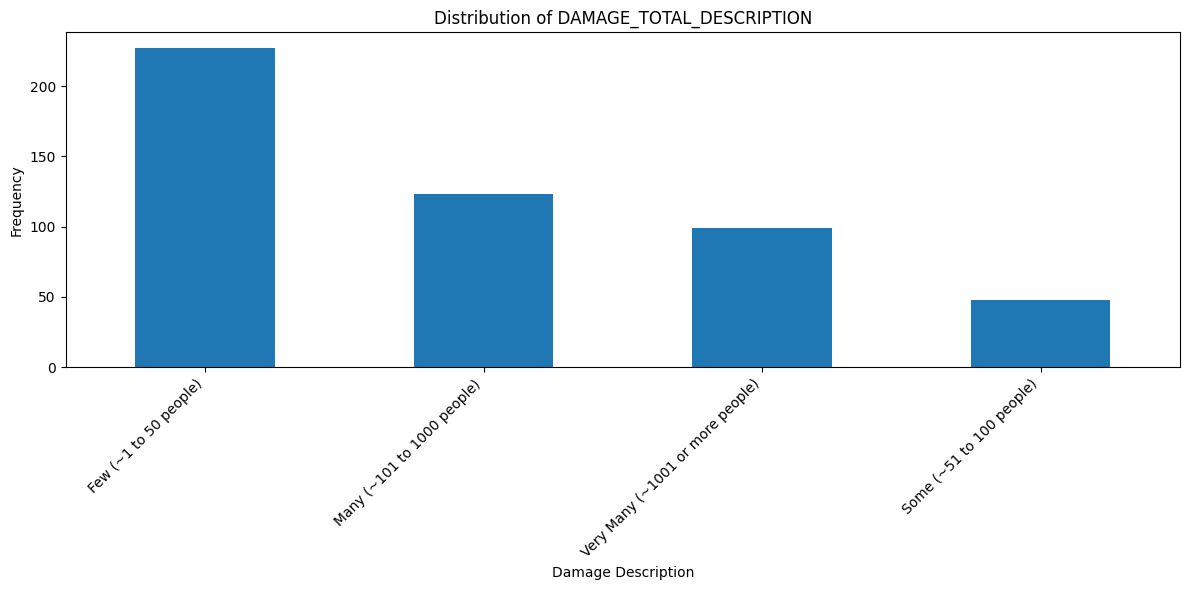

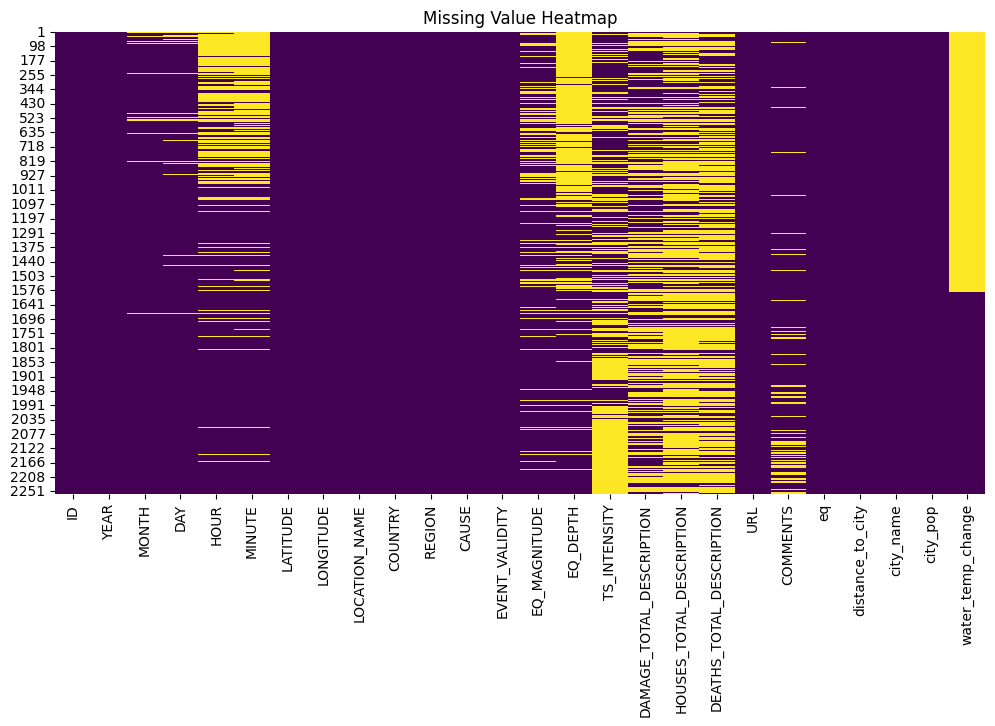


Missing value percentage:
 ID                           0.000000
YEAR                         0.000000
MONTH                        4.603807
DAY                          7.835325
HOUR                        42.098274
MINUTE                      45.329792
LATITUDE                     0.000000
LONGITUDE                    0.000000
LOCATION_NAME                0.398406
COUNTRY                      0.000000
REGION                       0.044267
CAUSE                        0.044267
EVENT_VALIDITY               0.000000
EQ_MAGNITUDE                34.749889
EQ_DEPTH                    59.849491
TS_INTENSITY                51.261620
DAMAGE_TOTAL_DESCRIPTION    53.297919
HOUSES_TOTAL_DESCRIPTION    73.173971
DEATHS_TOTAL_DESCRIPTION    70.163789
URL                          0.000000
COMMENTS                     7.259849
eq                           0.044267
distance_to_city             0.000000
city_name                    0.000000
city_pop                     0.000000
water_temp_change     

In [ ]:
# Show the distribution of total damage
print(len(tsu[(tsu['DEATHS_TOTAL_DESCRIPTION'].isna())]))
print(tsu['DEATHS_TOTAL_DESCRIPTION'].value_counts())
plt.figure(figsize=(12, 6))
tsu['DEATHS_TOTAL_DESCRIPTION'].value_counts().plot(kind='bar')
plt.title('Distribution of DAMAGE_TOTAL_DESCRIPTION')
plt.xlabel('Damage Description')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Show missing values
missing_percentage = df.isnull().sum() * 100 / len(df)

plt.figure(figsize=(12, 6))
sns.heatmap(tsu.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.show()

print("\nMissing value percentage:\n", missing_percentage)

In [ ]:
# Drop rows with missing values in the target variable
df_damage = tsu[~(tsu["DEATHS_TOTAL_DESCRIPTION"].isna())]

print(df_damage.dtypes)
print(f"df length: {df_damage.shape}")

df_damage.reset_index(inplace = True)

df_damage["DEATHS_TOTAL_DESCRIPTION"].value_counts()

ID                            int64
YEAR                          int64
MONTH                       float64
DAY                         float64
HOUR                        float64
MINUTE                      float64
LATITUDE                    float64
LONGITUDE                   float64
LOCATION_NAME                object
COUNTRY                      object
REGION                       object
CAUSE                        object
EVENT_VALIDITY               object
EQ_MAGNITUDE                float64
EQ_DEPTH                    float64
TS_INTENSITY                float64
DAMAGE_TOTAL_DESCRIPTION     object
HOUSES_TOTAL_DESCRIPTION     object
DEATHS_TOTAL_DESCRIPTION     object
URL                          object
COMMENTS                     object
eq                          float64
distance_to_city            float64
city_name                    object
city_pop                      int64
water_temp_change           float64
dtype: object
df length: (497, 26)


,count
DEATHS_TOTAL_DESCRIPTION,
Few (~1 to 50 people),227
Many (~101 to 1000 people),123
Very Many (~1001 or more people),99
Some (~51 to 100 people),48


## Feature engineering

In [ ]:
# Prepare the data for the k-NN model by encoding categorical features and scaling numerical features.

# Identify categorical and numerical features
categorical_cols = df_damage.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_damage.select_dtypes(include=['number']).columns.tolist()

# remove variable of interest
categorical_cols.remove('DEATHS_TOTAL_DESCRIPTION')

# remove variables with no importance
categorical_cols.remove('URL')
categorical_cols.remove('COMMENTS')
numerical_cols.remove('ID')
numerical_cols.remove('index')


# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(df_damage[categorical_cols])
feature_names = encoder.get_feature_names_out(categorical_cols)
df_encoded = pd.DataFrame(encoded_features, columns=feature_names)

# Scale numerical features
scaler = StandardScaler()
df_scaled_numerical = pd.DataFrame(scaler.fit_transform(df_damage[numerical_cols]), columns=numerical_cols)
df_scaled_numerical = df_damage[numerical_cols]

# Combine scaled numerical and encoded categorical features
df_prepared = pd.concat([df_scaled_numerical, df_encoded], axis=1)
df_prepared['DEATHS_TOTAL_DESCRIPTION'] = df_damage['DEATHS_TOTAL_DESCRIPTION']

display(df_prepared.head())
df_prepared.shape
df_prepared["DEATHS_TOTAL_DESCRIPTION"]

,YEAR,MONTH,DAY,HOUR,MINUTE,LATITUDE,LONGITUDE,EQ_MAGNITUDE,EQ_DEPTH,TS_INTENSITY,...,city_name_Tasikmalaya,city_name_Tehran,city_name_Thessaloniki,city_name_Tokyo,city_name_Tuxtla Gutierrez,city_name_Valparaiso,city_name_Vancouver,city_name_Yangon,city_name_Zamboanga City,DEATHS_TOTAL_DESCRIPTION
0,-1610,NaN,NaN,NaN,NaN,36.400,25.400,NaN,NaN,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Many (~101 to 1000 people)
1,-426,6.0,NaN,NaN,NaN,38.900,22.700,7.1,NaN,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Very Many (~1001 or more people)
2,-373,NaN,NaN,NaN,NaN,38.250,22.250,7.3,NaN,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Many (~101 to 1000 people)
3,79,8.0,24.0,7.0,NaN,40.821,14.426,NaN,NaN,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Very Many (~1001 or more people)
4,365,7.0,21.0,NaN,NaN,35.000,23.000,8.0,70.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Very Many (~1001 or more people)


,DEATHS_TOTAL_DESCRIPTION
0,Many (~101 to 1000 people)
1,Very Many (~1001 or more people)
2,Many (~101 to 1000 people)
3,Very Many (~1001 or more people)
4,Very Many (~1001 or more people)
...,...
492,Many (~101 to 1000 people)
493,Many (~101 to 1000 people)
494,Few (~1 to 50 people)
495,Few (~1 to 50 people)


In [ ]:
# drop all missing values just for this step, will revert after finding best features
df_prep_no_nan = df_prepared.dropna()

# Split data into features (X) and target (y)
X = df_prep_no_nan.drop('DEATHS_TOTAL_DESCRIPTION', axis=1)
y = df_prep_no_nan['DEATHS_TOTAL_DESCRIPTION']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2025)

display(X_train.head())
display(X_train.shape)
display(y_train.head())

,YEAR,MONTH,DAY,HOUR,MINUTE,LATITUDE,LONGITUDE,EQ_MAGNITUDE,EQ_DEPTH,TS_INTENSITY,...,city_name_Taizhong,city_name_Tasikmalaya,city_name_Tehran,city_name_Thessaloniki,city_name_Tokyo,city_name_Tuxtla Gutierrez,city_name_Valparaiso,city_name_Vancouver,city_name_Yangon,city_name_Zamboanga City
416,1995,7.0,30.0,5.0,11.0,-23.34,-70.294,8.0,46.0,1.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
437,2002,9.0,8.0,18.0,44.0,-3.26,142.940,7.6,13.0,1.08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
350,1968,4.0,1.0,0.0,42.0,32.30,132.500,7.5,30.0,1.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367,1975,10.0,31.0,8.0,28.0,12.54,125.993,7.6,50.0,-1.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
348,1968,5.0,16.0,0.0,48.0,40.80,143.200,8.2,7.0,2.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(53, 506)

,DEATHS_TOTAL_DESCRIPTION
416,Few (~1 to 50 people)
437,Few (~1 to 50 people)
350,Few (~1 to 50 people)
367,Few (~1 to 50 people)
348,Some (~51 to 100 people)


## KNN PFI

In [ ]:
# Initialize lists to store results
k_values = [3, 5, 7, 10]
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

for k in k_values:
    # Instantiate and train k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Make predictions
    y_pred = knn.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted') # Use weighted average for multi-class
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    # Store results
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)

    print(f"Results for k = {k}:")
    print(f"Accuracy: {accuracy}")
    print(f"F1-score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

print("\nSummary of Results:")
for i, k in enumerate(k_values):
    print(f"k = {k}: Accuracy = {accuracy_scores[i]}, F1-score = {f1_scores[i]}, Precision = {precision_scores[i]}, Recall = {recall_scores[i]}")

Results for k = 3:
Accuracy: 0.42857142857142855
F1-score: 0.3535714285714286
Precision: 0.32142857142857145
Recall: 0.42857142857142855
Results for k = 5:
Accuracy: 0.42857142857142855
F1-score: 0.2571428571428571
Precision: 0.18367346938775508
Recall: 0.42857142857142855
Results for k = 7:
Accuracy: 0.42857142857142855
F1-score: 0.2571428571428571
Precision: 0.18367346938775508
Recall: 0.42857142857142855
Results for k = 10:
Accuracy: 0.42857142857142855
F1-score: 0.2571428571428571
Precision: 0.18367346938775508
Recall: 0.42857142857142855

Summary of Results:
k = 3: Accuracy = 0.42857142857142855, F1-score = 0.3535714285714286, Precision = 0.32142857142857145, Recall = 0.42857142857142855
k = 5: Accuracy = 0.42857142857142855, F1-score = 0.2571428571428571, Precision = 0.18367346938775508, Recall = 0.42857142857142855
k = 7: Accuracy = 0.42857142857142855, F1-score = 0.2571428571428571, Precision = 0.18367346938775508, Recall = 0.42857142857142855
k = 10: Accuracy = 0.4285714285714

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

## PFI using KNN

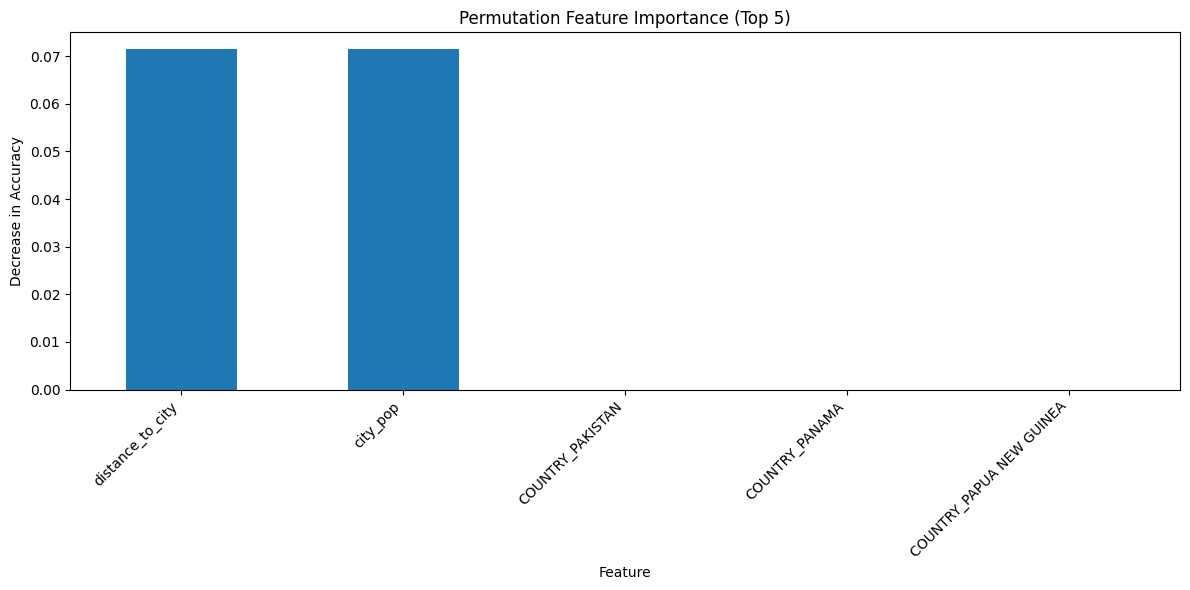

Top 5 most important features:
distance_to_city            0.071429
city_pop                    0.071429
COUNTRY_PAKISTAN            0.000000
COUNTRY_PANAMA              0.000000
COUNTRY_PAPUA NEW GUINEA    0.000000
dtype: float64


In [ ]:
# Use the best k value from previous step, which was k = 3
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Calculate permutation feature importance
feature_importances = pd.Series(index=X_train.columns)
baseline_accuracy = accuracy_score(y_test, knn.predict(X_test))

for col in X_train.columns:
    X_test_shuffled = X_test.copy()
    X_test_shuffled[col] = np.random.permutation(X_test_shuffled[col])
    shuffled_accuracy = accuracy_score(y_test, knn.predict(X_test_shuffled))
    feature_importances[col] = baseline_accuracy - shuffled_accuracy

# Sort feature importances in descending order
feature_importances = feature_importances.sort_values(ascending=False)

# Visualize feature importances
plt.figure(figsize=(12, 6))
feature_importances[:5].plot(kind='bar') # Only plot top 20 for better visualization
plt.title('Permutation Feature Importance (Top 5)')
plt.xlabel('Feature')
plt.ylabel('Decrease in Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print the top 5 most important features
print("Top 5 most important features:")
print(feature_importances[:5])

In [ ]:
print("\nMissing value percentage:\n", missing_percentage)


Missing value percentage:
 ID                           0.000000
YEAR                         0.000000
MONTH                        4.603807
DAY                          7.835325
HOUR                        42.098274
MINUTE                      45.329792
LATITUDE                     0.000000
LONGITUDE                    0.000000
LOCATION_NAME                0.398406
COUNTRY                      0.000000
REGION                       0.044267
CAUSE                        0.044267
EVENT_VALIDITY               0.000000
EQ_MAGNITUDE                34.749889
EQ_DEPTH                    59.849491
TS_INTENSITY                51.261620
DAMAGE_TOTAL_DESCRIPTION    53.297919
HOUSES_TOTAL_DESCRIPTION    73.173971
DEATHS_TOTAL_DESCRIPTION    70.163789
URL                          0.000000
COMMENTS                     7.259849
eq                           0.044267
distance_to_city             0.000000
city_name                    0.000000
city_pop                     0.000000
water_temp_change     

Results are varying wildly every run (without random_state = 2025). In an effort to not lose too much data and hopefully keep results more stable, I will be selecting top features that don't have too many missing values within the dataset, and then adding some of my own feature selections.

In [ ]:
df_prepared1 = df_prepared.dropna(subset = ["MONTH", "EQ_MAGNITUDE", 'city_pop', 'distance_to_city', 'water_temp_change'])

# Split data into features (X) and target (y)
X = df_prepared1[["YEAR", 'MONTH', 'LATITUDE', 'LONGITUDE', 'EQ_MAGNITUDE', 'water_temp_change', 'city_pop', 'distance_to_city']]
y = df_prepared1['DEATHS_TOTAL_DESCRIPTION']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2025)

display(X_train.head())
display(X_train.shape)
display(y_train.head())

,YEAR,MONTH,LATITUDE,LONGITUDE,EQ_MAGNITUDE,water_temp_change,city_pop,distance_to_city
474,2012,8.0,10.811,126.638,7.6,7.805,980070,304.872839
460,2009,9.0,-0.720,99.867,7.5,7.424,980455,59.697385
488,2017,6.0,38.930,26.365,6.3,9.599,2992953,88.659351
405,1993,3.0,-14.385,-178.252,6.4,2.146,1606564,2584.032191
470,2012,3.0,16.493,-98.231,7.4,7.805,704559,172.364474


(132, 8)

,DEATHS_TOTAL_DESCRIPTION
474,Few (~1 to 50 people)
460,Very Many (~1001 or more people)
488,Few (~1 to 50 people)
405,Few (~1 to 50 people)
470,Few (~1 to 50 people)


## model set 1

In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted') # Use weighted average for multi-class
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.5757575757575758
F1-score: 0.4207459207459207
Precision: 0.3314967860422406
Recall: 0.5757575757575758


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# random forest
forest = RandomForestClassifier(15, max_depth = 5, random_state = 2025)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted') # Use weighted average for multi-class
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.5454545454545454
F1-score: 0.4479901051329622
Precision: 0.44747474747474747
Recall: 0.5454545454545454


In [ ]:
# decision tree classifier
clf = DecisionTreeClassifier(random_state = 2025)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = "weighted")
precision = precision_score(y_test, y_pred, average = "weighted")
recall = recall_score(y_test, y_pred, average = "weighted")

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.45454545454545453
F1-score: 0.44276094276094274
Precision: 0.43376623376623374
Recall: 0.45454545454545453


## model set 2

death_severity
0    275
1    222
Name: count, dtype: int64
Resampled dataset shape before random oversampling: Counter({0: 95, 1: 37})
Resampled dataset shape after random oversampling: Counter({0: 95, 1: 95})
Accuracy: 0.5454545454545454
F1-score: 0.4
Precision: 0.3125
Recall: 0.5555555555555556


<ipython-input-292-a3c6213406bb>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_damage["death_severity"] = df_damage["DEATHS_TOTAL_DESCRIPTION"].apply(severity_death)


,count
death_severity,
0,95
1,37


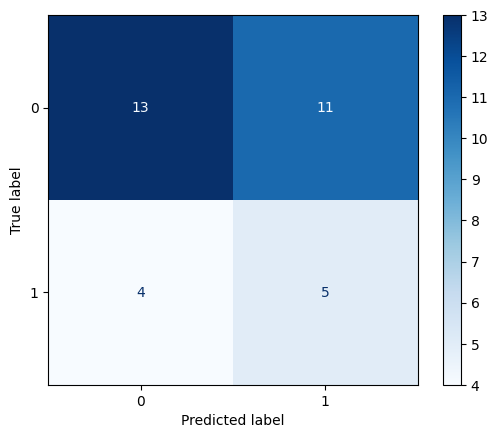

In [ ]:
# def severity(damage):
#   if pd.isna(damage):
#     return None
#   if damage == "Limited (<$1 million)" or damage == "Moderate (~$1 to $5 million)":
#     return 0
#   else:
#     return 1
# # add in column for damage severity (enabling us to do logistic regression)
# df_damage["damage_severity"] = df_damage["DAMAGE_TOTAL_DESCRIPTION"].apply(severity)
# print(df_damage["damage_severity"].value_counts())

def severity_death(death):
  if pd.isna(death):
    return None
  if "Few (~1 to 50 people)" == death or "Some (~51 to 100 people)" == death:
    return 0
  else:
    return 1
# add in column for damage severity (enabling us to do logistic regression)
df_damage["death_severity"] = df_damage["DEATHS_TOTAL_DESCRIPTION"].apply(severity_death)
print(df_damage["death_severity"].value_counts())

# now use KNN to look at severe vs. not
df_dam = df_damage.dropna(subset = ["MONTH", "EQ_MAGNITUDE", 'water_temp_change', 'city_pop', 'distance_to_city'])
X = df_dam[["YEAR", 'MONTH', 'LATITUDE', 'LONGITUDE', 'EQ_MAGNITUDE', 'water_temp_change', 'city_pop', 'distance_to_city']]
y = df_dam['death_severity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 2025)

print("Resampled dataset shape before random oversampling:", Counter(y_train))

# oversample
rus = RandomOverSampler(sampling_strategy = "minority", random_state=2025)
X_train1, y_train1 = rus.fit_resample(X_train, y_train)
print("Resampled dataset shape after random oversampling:", Counter(y_train1))

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train1, y_train1)

y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

y_train.value_counts()

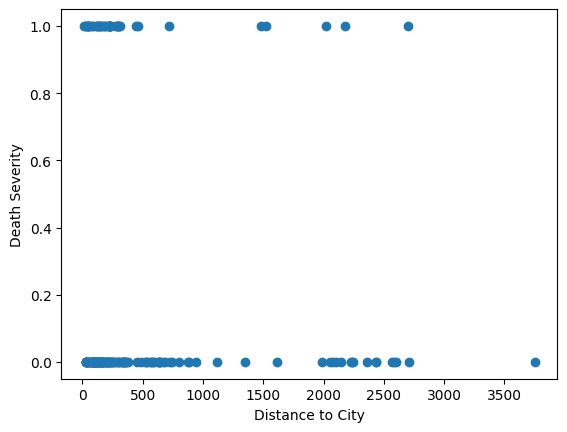

In [ ]:
# map the distance to city feature
plt.plot(df_dam["distance_to_city"], df_dam["death_severity"], "o")
plt.xlabel("Distance to City")
plt.ylabel("Death Severity")
plt.show()

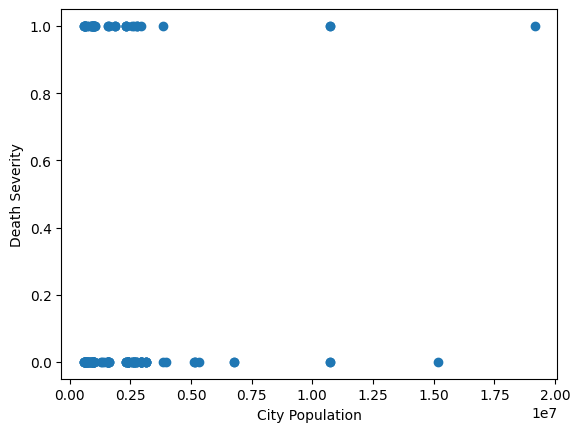

In [ ]:
# map the city population feature
plt.plot(df_dam["city_pop"], df_dam["death_severity"], "o")
plt.xlabel("City Population")
plt.ylabel("Death Severity")
plt.show()

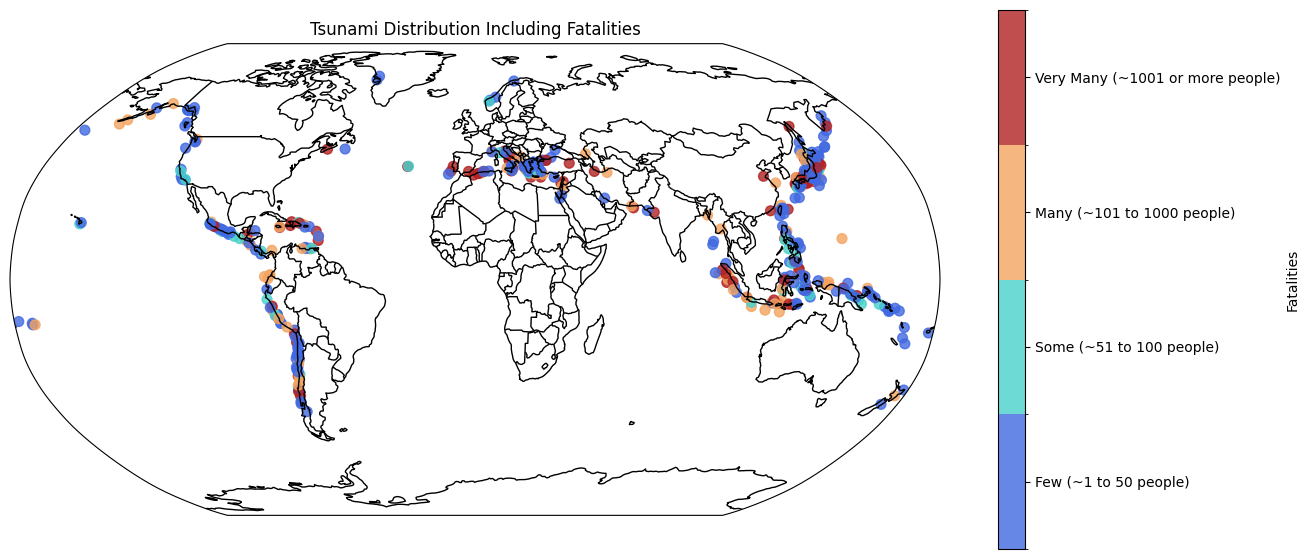

In [ ]:
# Create a color mapping for death caused
damage_colors = {
    'Few (~1 to 50 people)': 'royalblue',
    'Some (~51 to 100 people)': 'mediumturquoise',
    'Many (~101 to 1000 people)': 'sandybrown',
    'Very Many (~1001 or more people)': 'firebrick',
}

# Create the figure and axes
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# Add coastlines and land features
ax.coastlines()
ax.add_feature(cfeature.BORDERS)


# Map event validity to colors
categories = list(damage_colors.keys())
colors = list(damage_colors.values())

cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(range(len(categories) + 1), cmap.N)


# Create the scatter plot with color mapping
scatter = ax.scatter(
    df_damage['LONGITUDE'],
    df_damage['LATITUDE'],
    c=[categories.index(c) for c in df_damage['DEATHS_TOTAL_DESCRIPTION']],
    cmap=cmap,
    norm=norm,
    alpha=0.8,
    s=50,
    transform=ccrs.PlateCarree(),
)


# Add a colorbar
cbar = plt.colorbar(scatter, ax=ax, ticks=[i + 0.5 for i in range(len(categories))], shrink=0.7)
cbar.set_label('Fatalities')
cbar.ax.set_yticklabels(categories)


# Set the title and axis labels
plt.title('Tsunami Distribution Including Fatalities')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Set the extent of the map (adjust as needed)
ax.set_global()

# Display the plot
plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(15,5))
# sns.pairplot(data = df_damage, hue = "DEATHS_TOTAL_DESCRIPTION")

# plt.show()

Accuracy: 0.7272727272727273
F1-score: 0.0
Precision: 0.0
Recall: 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


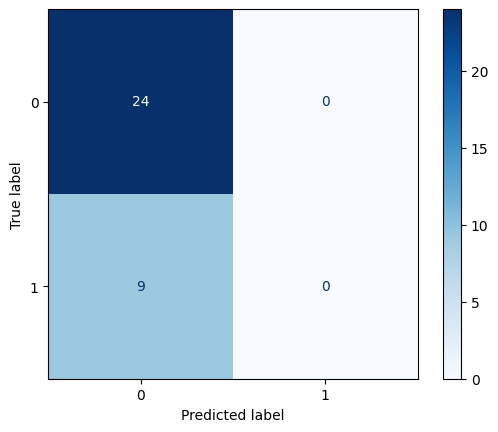

In [ ]:
# logistic regression
# instantiate the model
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


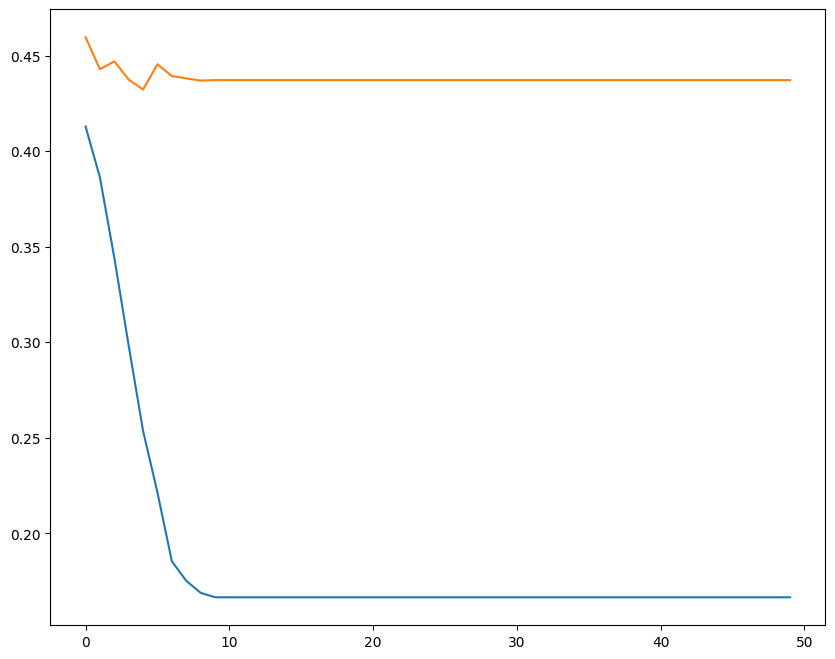

In [ ]:
# random forest max depth selection
train_err = np.zeros(50)
test_err = np.zeros(50)

for i in range(0,50):
  print(i)
  forest = RandomForestRegressor(15, max_depth=i+1, random_state = 2025)
  forest.fit(X_train, y_train)
  ypred_train = forest.predict(X_train)
  ypred_test = forest.predict(X_test)
  train_err[i] = np.sqrt(np.mean((y_train-ypred_train)**2))
  test_err[i] = np.sqrt(np.mean((y_test-ypred_test)**2))

fig = plt.figure(figsize=(10,8))

plt.plot(train_err)
plt.plot(test_err)

Accuracy: 0.7272727272727273
F1-score: 0.18181818181818182
Precision: 0.5
Recall: 0.1111111111111111


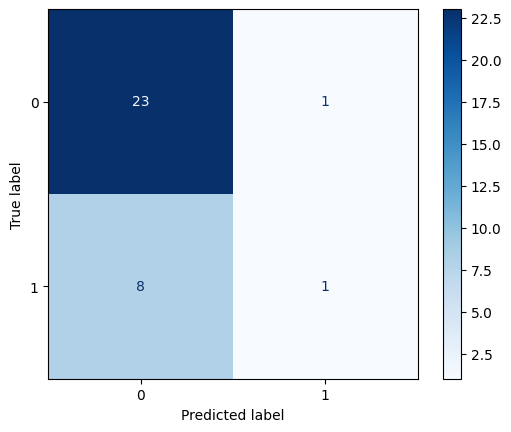

In [ ]:
# random forest
forest = RandomForestClassifier(15, max_depth = 4, random_state = 2025)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

Accuracy: 0.7878787878787878
F1-score: 0.5882352941176471
Precision: 0.625
Recall: 0.5555555555555556


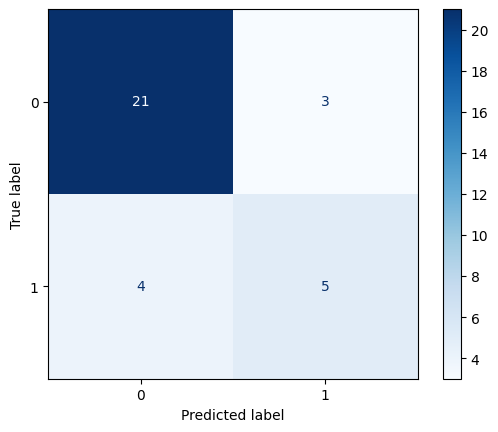

In [ ]:
# decision tree
clf = DecisionTreeClassifier(random_state = 2025)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

## model set 3

In [ ]:
# df_num = df.groupby('YEAR')["ID"].count().reset_index().rename(columns = {"ID": "Number of Tsunamis"})
# df_num1 = df_num[df_num["YEAR"] >= 1850]
# df_num1.plot("YEAR", "Number of Tsunamis", kind = "scatter")
# plt.show()

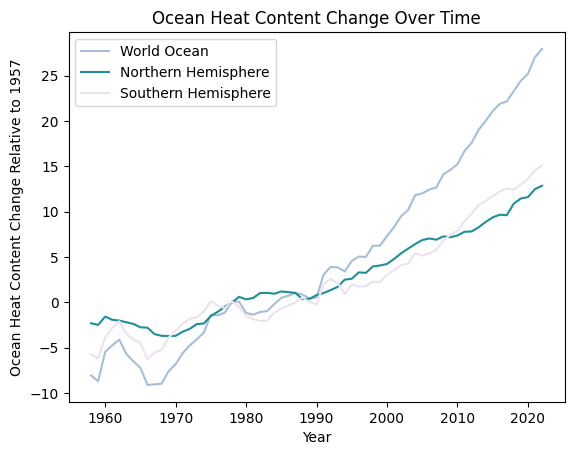

In [ ]:
# map ocean heat content change in changes since 1957
colors = {"WO": "#a6bddb", "NH": "#1c9099", "SH": "#ece2f0"}
temp_cols = water_temp[["WO", "NH", "SH"]]
columns = {"WO": "World Ocean", "NH": "Northern Hemisphere", "SH": "Southern Hemisphere"}

for col in temp_cols.columns:
    plt.plot(water_temp["YEAR"], water_temp[col], color=colors[col], label=columns[col])

plt.legend()
plt.xlabel("Year")
plt.ylabel("Ocean Heat Content Change Relative to 1957")
plt.title("Ocean Heat Content Change Over Time")
plt.show()

In [ ]:
# merge the water temp data set with the value counts of tsunamis after 1957
year_count = water_temp.merge(df_1958["YEAR"].value_counts(), on = "YEAR")
print(len(year_count))
year_count.head()

63


,YEAR,WO,WOse,NH,NHse,SH,SHse,count
0,1958,-8.059,2.017,-2.321,0.851,-5.738,1.166,3
1,1959,-8.713,2.036,-2.505,0.824,-6.208,1.212,5
2,1960,-5.479,1.893,-1.587,0.746,-3.892,1.148,7
3,1961,-4.762,1.773,-1.936,0.711,-2.826,1.061,10
4,1962,-4.121,1.728,-2.022,0.645,-2.100,1.082,6


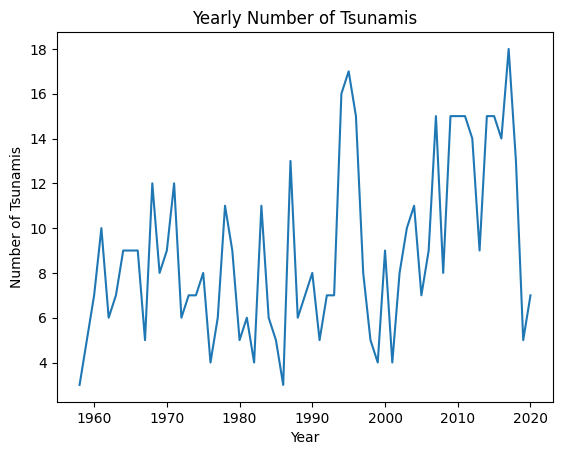

In [ ]:
plt.plot(year_count["YEAR"], year_count["count"], label=col)
plt.ylabel("Number of Tsunamis")
plt.xlabel("Year")
plt.title("Yearly Number of Tsunamis")
plt.show()

In [ ]:
# just looking at year
# count_X_train = year_count.iloc[:, :1][:-10]
# count_X_test = year_count.iloc[:, :1][-10:]

# looking at all variables
# count_X_train = year_count.iloc[:, :7][:-10]
# count_X_test = year_count.iloc[:, :7][-10:]

# just year + water heat content change
count_X_train = year_count[["YEAR", "NH", "SH"]][:-10]
count_X_test = year_count[["YEAR", "NH", "SH"]][-10:]


# Split the targets into training/testing sets
count_y_train = year_count["count"][:-10]
count_y_test = year_count["count"][-10:]

len(count_X_train), len(count_X_test), len(count_y_train), len(count_y_test)

(53, 10, 53, 10)

In [ ]:
# linear regression
# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(count_X_train, count_y_train)

# Make predictions using the testing set
count_y_pred = regr.predict(count_X_test)

In [ ]:
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(count_y_test, count_y_pred))

r2 = r2_score(count_y_test, count_y_pred)
print('r2: %.2f' % r2)


Coefficients: 
 [ 0.0198541  -0.14177476  0.36760476]
Mean squared error: 16.74
r2: -0.10


    YEAR      WO   WOse      NH   NHse      SH   SHse
55  2013  19.004  0.198   8.260  0.088  10.745  0.110
56  2014  20.001  0.194   8.851  0.083  11.149  0.111
57  2015  21.074  0.190   9.359  0.081  11.714  0.108
58  2016  21.879  0.184   9.654  0.079  12.225  0.104
59  2017  22.147  0.190   9.599  0.088  12.548  0.102
60  2018  23.294  0.211  10.883  0.085  12.411  0.125
61  2019  24.442  0.179  11.444  0.085  12.999  0.094
62  2020  25.186  0.183  11.596  0.087  13.591  0.095
63  2021  27.021  0.185  12.471  0.088  14.550  0.097
64  2022  27.939  0.186  12.849  0.090  15.090  0.096


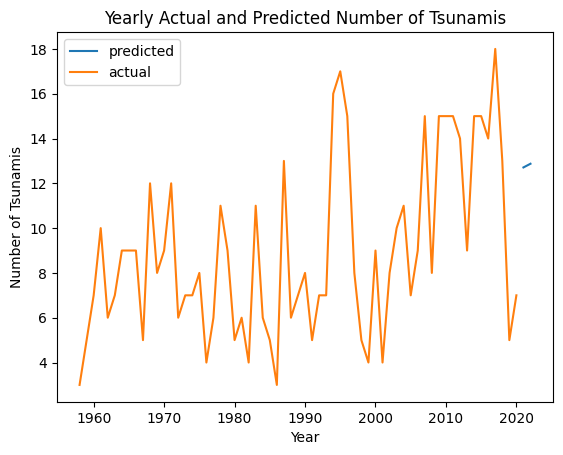

In [ ]:
# predict the number of tsunamis that formed in 2021 and 2022 based off of their actual
#   ocean heat content changes
print(water_temp.tail(10))
water_temp_21_22 = water_temp.iloc[-2:][["YEAR", "NH", "SH"]]

regr = LinearRegression()

# Train the model using the training sets
regr.fit(count_X_train, count_y_train)

# Make predictions using the testing set
count_y_pred = regr.predict(water_temp_21_22)

plt.plot(water_temp_21_22["YEAR"], count_y_pred, label = "predicted")
plt.plot(year_count["YEAR"], year_count["count"], label = "actual")
plt.ylabel("Number of Tsunamis")
plt.xlabel("Year")
plt.title("Yearly Actual and Predicted Number of Tsunamis")
plt.legend()
plt.show()

In [ ]:
# xgboost
model = xgb.XGBRegressor(n_estimators=15, max_depth=3, learning_rate=0.4)

#LBG
#model = lgb.LGBMRegressor(n_estimators=10, max_depth=6, learning_rate=0.4)

model.fit(count_X_train, count_y_train)
y_pred = model.predict(count_X_test)
rmse = root_mean_squared_error(count_y_test, y_pred)

#print("Coefficients: \n", model.coef_)

print(f"RMSE: {rmse:.3f}")

print("Mean squared error: %.2f" % mean_squared_error(count_y_test, y_pred))

r2 = r2_score(count_y_test, y_pred)
print('r2: %.2f' % r2)

RMSE: 4.165
Mean squared error: 17.34
r2: -0.14


In [ ]:
# decision tree regressor
clf = DecisionTreeRegressor(random_state = 2025)
clf.fit(count_X_train, count_y_train)
y_pred = clf.predict(count_X_test)

#print("Coefficients: \n", clf.coef_)

print("Mean squared error: %.2f" % mean_squared_error(count_y_test, y_pred))

r2 = r2_score(count_y_test, y_pred)
print('r2: %.2f' % r2)

Mean squared error: 21.50
r2: -0.41


In [ ]:
# random forest classifier
forest = RandomForestRegressor(15, max_depth = 8, random_state = 2025)
forest.fit(count_X_train, count_y_train)
y_pred = forest.predict(count_X_test)

# print("Coefficients: \n", .coef_)

print("Mean squared error: %.2f" % mean_squared_error(count_y_test, y_pred))

r2 = r2_score(count_y_test, y_pred)
print('r2: %.2f' % r2)

Mean squared error: 21.50
r2: -0.41
